In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

# Dimensions of a Data Table

You have likely used the word "dimension" in a geometric sense–a square is two-dimensional while a cube is three-dimensional. We also apply this geometric lens towards data. Consider the two-column table below of height and weight measurements for 251 men.

In [3]:
#http://jse.amstat.org/datasets/fat.txt
fat = (
    pd.read_fwf("fat.dat.txt", colspecs = [(17, 21), (23, 29), (35, 37),
                                            (39, 45), (48, 53), (73, 77),
                                            (80, 85), (88, 93)], header=None,
                names = ["% fat", "density", "age", "weight", "height", "neck", "chest", "abdomen"])
    .query('height >= 40')
)
df = fat[['height', 'weight']]

In [4]:
df

,height,weight
0,67.75,154.25
1,72.25,173.25
2,66.25,154.00
...,...,...
249,66.00,186.75
250,70.50,190.75
251,70.00,207.50


If we view this data in a row-oriented way, we can think of each row of data as a vector with two elements. For example, the first row of `df` corresponds to the vector $ [ 67.75, 154.25 ] $. If we draw a point at the endpoint of each row vector on the coordinate plane, we produce the familiar scatter plot of weight on height:

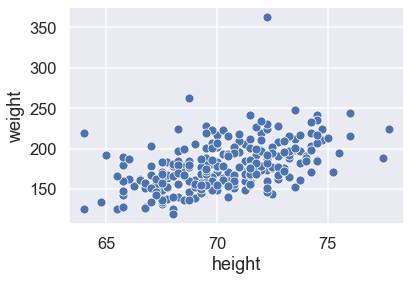

In [5]:
sns.scatterplot(data=df, x='height', y='weight');

What about a table with two columns: one for height in inches and one for height in feet?

In [6]:
heights = (
    df['height']
    .rename('inches')
    .to_frame()
    .assign(feet=lambda df: df['inches'] / 12)
)

In [7]:
heights

,inches,feet
0,67.75,5.65
1,72.25,6.02
2,66.25,5.52
...,...,...
249,66.00,5.50
250,70.50,5.88
251,70.00,5.83


Each row vector of this data table contains two elements as before. Yet a scatter plot reveals that all the data lie along one dimension, not two:

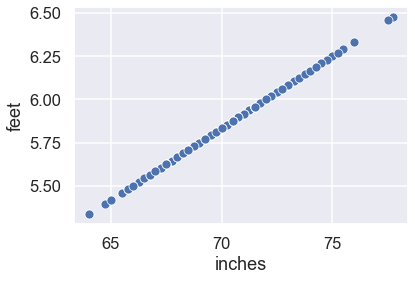

In [8]:
sns.scatterplot(data=heights, x='inches', y='feet');

Intuitively, we can use a one-dimensional line to represent the data rather than the two-dimensional plane of the scatter plot. The **intrinsic dimension**, or simply the dimension, of the `heights` table is 1, not 2. 

### The Dimension of a Data Table is the Rank

Observe that the `feet` column of the `heights` table is the `inches` column converted to feet by dividing each value by 12:

In [9]:
heights

,inches,feet
0,67.75,5.65
1,72.25,6.02
2,66.25,5.52
...,...,...
249,66.00,5.50
250,70.50,5.88
251,70.00,5.83


The `feet` column is a *linear combination* of the `inches` column. We might view the `feet` column as contributing no extra information than the `inches` column. If the `heights` table lost the `feet` column, we could reconstruct the `feet` column exactly using the `inches` column alone. A linearly dependent column does not "add" another dimension to a data table.

In other words, the dimension of a data table is the number of linearly independent columns in the table, or equivalently the **matrix rank** of the the data.

### Intuition for Reducing Dimensions

In most real-world scenarios, though, data seldomly contain columns that are exact linear combinations of other columns because of measurement error. Consider these measurements of overall density vs percent fat for individuals:

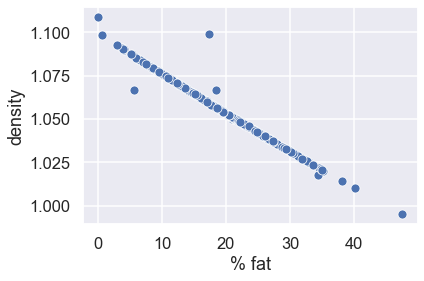

In [10]:
sns.scatterplot(data=fat, x='% fat', y='density');

The scatter plot shows that density is not a linear combination of percent fat, yet density 
and percent fat appear "almost" linearly dependent. Intuitively, we can closely approximate density values using a linear combination of the percent fat values.

We use **dimensionality reduction** techniques to automatically perform these approximations rather than manually examine individual pairs of data variables. Dimensionality reduction techniques are especially useful for exploratory data analysis on high-dimensional data. Consider the following data table of US House of Representative votes in September 2019:

In [11]:
df = pd.read_csv('vote_pivot.csv', index_col='member')
df

,515,516,517,518,...,552,553,554,555
member,,,,,,,,,
A000055,1,0,0,0,...,0,0,1,0
A000367,0,0,0,0,...,1,1,0,1
A000369,1,1,0,0,...,0,0,1,0
...,...,...,...,...,...,...,...,...,...
Y000062,1,1,1,1,...,1,1,1,1
Y000065,0,0,0,0,...,0,0,1,0
Z000017,1,1,0,0,...,0,0,1,0


In this dataset, every row corresponds to a single congressperson, and every column contains that congressperson's vote on a single bill: a `1` means the person voted for the bill and a `0` means the person voted against the bill.

This dataset contains 41 numeric dimensions:

In [12]:
np.linalg.matrix_rank(df)

41

In other words, none of the vote columns are linearly dependent. This implies that no two congresspeople voted exactly the same on these 41 bills, and that no two congresspeople voted exactly opposite from each other.

But we don't expect the votes to be completely random, either. In 2019 the US had two dominant political parties, the Democratic and the Republican parties, and we expect that in most cases a congressperson will vote similarly to other members of their political party.

That is, even though the matrix of votes contains 41 dimensions, we might preserve useful patterns in the data even after performing dimensionality reduction to decrease the number of data table dimensions.

The rest of this chapter introduces a useful technique for dimensionality reduction called **principal component analysis** or PCA for short. In the figure below, we use PCA to approximate the vote data with just 2 dimensions, then create a scatter plot using the 2-dimensional approximation.

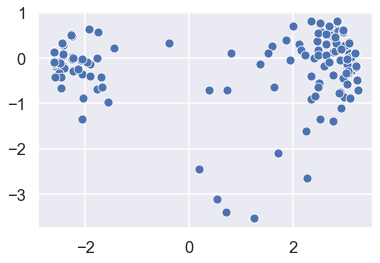

In [13]:
df_c = df - np.mean(df, axis = 0)
u, s, vt = np.linalg.svd(df_c, full_matrices = False)
pcs = u * s
sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1]);

In the plot above, every point corresponds to one congressperson. We can color each point according to the political party of the congressperson:

In [14]:
legs = pd.read_csv('legislators.csv')

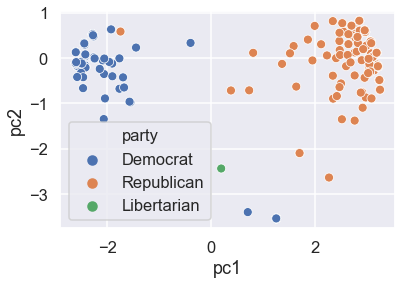

In [16]:
vote2d = pd.DataFrame({
    'member': df.index,
    'pc1': pcs[:, 0],
    'pc2': pcs[:, 1]
}).merge(legs, left_on='member', right_on='leg_id')
sns.scatterplot(data = vote2d,
                x="pc1", y="pc2", hue="party",
                hue_order=['Democrat', 'Republican', 'Libertarian']);

In this example, PCA successfully finds 2 dimensions that summarize the original 41 dimensions–these two dimensions capture the distinct voting patterns of political parties within the House of Representatives.